In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import glob  # Filename pattern matching
import random
import cv2  # Computer vision
from PIL import Image  # Image processing

import torch
import torchvision  # Computer vision tools
import torch.nn as nn  # Neural network layers
import torch.nn.functional as F  # Neural network functions
import torch.utils.data as data  # Data handling utilities
import torchvision.transforms as tt  # Image transformations
import albumentations as A  # Image augmentations
from tqdm import tqdm  # Progress bar
from mpl_toolkits.axes_grid1 import ImageGrid  # Image grid layout
from torch.utils.data import DataLoader  # Data loading
from torchvision.utils import make_grid  # Create image grids
from sklearn.model_selection import train_test_split
device = "cuda" if torch.cuda.is_available() else "cpu"  # Select GPU if available, otherwise CPU
print("Using {} device".format(device))  # Print the selected device


Using cuda device


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"  # Select GPU if available, otherwise CPU                    
  
print("Using {} device".format(device))  # Print the selected device

def set_seed(seed=0):  # Function to set random seed for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)  #
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed()

## Load files path in a dataframe
ROOT_PATH = 'kaggle_3m/'

# Using glob.glob to collect paths of all mask files in subdirectories
mask_files = glob.glob(ROOT_PATH + '*/*_mask*')
image_files = [file.replace('_mask', '') for file in mask_files]

# Defining a function diagnosis(mask_path) that returns 1
#if the maximum pixel value in the mask image (read using cv2) is greater than 0
def diagnosis(mask_path):
    return 1 if np.max(cv2.imread(mask_path)) > 0 else 0

files_df = pd.DataFrame({"image_path": image_files,
                  "mask_path": mask_files,
                  "diagnosis": [diagnosis(x) for x in mask_files]})

files_df

Using cuda device


,image_path,mask_path,diagnosis
0,kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_1...,kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_1...,0
1,kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_1...,kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_1...,1
2,kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_1...,kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_1...,1
3,kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_1...,kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_1...,1
4,kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_1...,kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_1...,1
...,...,...,...
3924,kaggle_3m\TCGA_HT_A61B_19991127\TCGA_HT_A61B_1...,kaggle_3m\TCGA_HT_A61B_19991127\TCGA_HT_A61B_1...,0
3925,kaggle_3m\TCGA_HT_A61B_19991127\TCGA_HT_A61B_1...,kaggle_3m\TCGA_HT_A61B_19991127\TCGA_HT_A61B_1...,0
3926,kaggle_3m\TCGA_HT_A61B_19991127\TCGA_HT_A61B_1...,kaggle_3m\TCGA_HT_A61B_19991127\TCGA_HT_A61B_1...,0
3927,kaggle_3m\TCGA_HT_A61B_19991127\TCGA_HT_A61B_1...,kaggle_3m\TCGA_HT_A61B_19991127\TCGA_HT_A61B_1...,0


In [8]:
print("Total of No Tumor:", files_df['diagnosis'].value_counts()[0])
print("Total of Tumor:", files_df['diagnosis'].value_counts()[1])

train_df, val_df = train_test_split(files_df, stratify=files_df['diagnosis'], test_size=0.1, random_state=0)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df['diagnosis'], test_size=0.15, random_state=0)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("Train: {}\nVal: {}\nTest: {}".format(train_df.shape, val_df.shape, test_df.shape))


Total of No Tumor: 2556
Total of Tumor: 1373
Train: (3005, 3)
Val: (393, 3)
Test: (531, 3)


In [9]:
class BrainDataset(data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 0])
        image = np.array(image)/255.  
        mask = cv2.imread(self.df.iloc[idx, 1], 0)
        mask = np.array(mask)/255.

        if self.transform is not None:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']

        image = image.transpose((2,0,1))  
        image = torch.from_numpy(image).type(torch.float32)
        image = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
        mask = np.expand_dims(mask, axis=-1).transpose((2,0,1))
        mask = torch.from_numpy(mask).type(torch.float32)

        return image, mask

# Define transformations for training, validation, and testing datasets using Albumentations library.
train_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),  # Resize images to 128x128 pixels
    A.HorizontalFlip(p=0.5),  # Apply horizontal flip with 50% probability
    A.VerticalFlip(p=0.5),  # Apply vertical flip with 50% probability
    A.RandomRotate90(p=0.5),  # Rotate randomly by 90 degrees with 50% probability
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),  # Randomly shift, scale, and rotate
])

val_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),  # Resize images to 128x128 pixels
    A.HorizontalFlip(p=0.5),  # Apply horizontal flip with 50% probability (for data augmentation)
])

test_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),  # Resize images to 128x128 pixels
])

train_ds = BrainDataset(train_df, train_transform)
val_ds = BrainDataset(val_df, val_transform)
test_ds = BrainDataset(test_df, test_transform)

def dataset_info(dataset):
    print(f'Size of dataset: {len(dataset)}')
    index = random.randint(1, 40)
    img, label = dataset[index]
    print(f'Sample-{index} Image size: {img.shape}, Mask: {label.shape}\n')


In [10]:
print('Train dataset:')
dataset_info(train_ds)
print('Validation dataset:')
dataset_info(val_ds)
print('Test dataset:')
dataset_info(test_ds)


Train dataset:
Size of dataset: 3005
Sample-25 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])

Validation dataset:
Size of dataset: 393
Sample-23 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])

Test dataset:
Size of dataset: 531
Sample-19 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])



In [12]:
## Creating Dataloaders

batch_size = 16

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=0,
                      pin_memory=True)
val_dl = DataLoader(val_ds,
                    batch_size,
                    num_workers=0,
                    pin_memory=True)
test_dl = DataLoader(test_ds,
                    batch_size,
                    num_workers=0,
                    pin_memory=True)


In [14]:
# Defines the DoubleConv class, consisting of two consecutive
# convolutional layers each followed by BatchNorm and ReLU.

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))
    def forward(self, x):
        return self.double_conv(x)

# Defines the Down class, which performs downscaling using MaxPool
# followed by DoubleConv.
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels))
    def forward(self, x):
        return self.maxpool_conv(x)

# Defines the Up class, which performs upscaling followed by DoubleConv.
class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels//2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX//2, diffX-diffX//2,
                        diffY//2, diffY-diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# Defines the OutConv class, which performs a 1x1 convolution followed by Sigmoid activation.
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid())
    def forward(self, x):
        return self.conv(x)

In [15]:
# Defines the UNet class, a convolutional neural network architecture
# for semantic segmentation.
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

    # Encoder (downsampling path)
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024//factor)

    # Decoder (upsampling path)
        self.up1 = Up(1024, 512//factor, bilinear)
        self.up2 = Up(512, 256//factor, bilinear)
        self.up3 = Up(256, 128//factor, bilinear)
        self.up4 = Up(128, 64, bilinear)

    # Output layer
        self.outc = OutConv(64, n_classes)

    def forward(self, x):

    # Encoder path
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

    # Decoder path with skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

    # Final output
        logits = self.outc(x)
        return logits

In [17]:
model = UNet(3, 1).to(device)
model.load_state_dict(torch.load('brain-mri-unet.pth', weights_only=True))  # Load the saved model
model.eval()  # Set the model to evaluation mode


UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [18]:

# Function to calculate the accuracy of the model
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            predicted = (outputs > 0.5).float()
            total += masks.numel()
            correct += (predicted == masks).sum().item()
    accuracy = correct / total
    return accuracy

accuracy = calculate_accuracy(test_dl, model)
print(f'Model Accuracy: {accuracy:.4f}')

Model Accuracy: 0.9954


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.66178656].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.66178656].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9471896].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9471896].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6334641].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6334641].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.

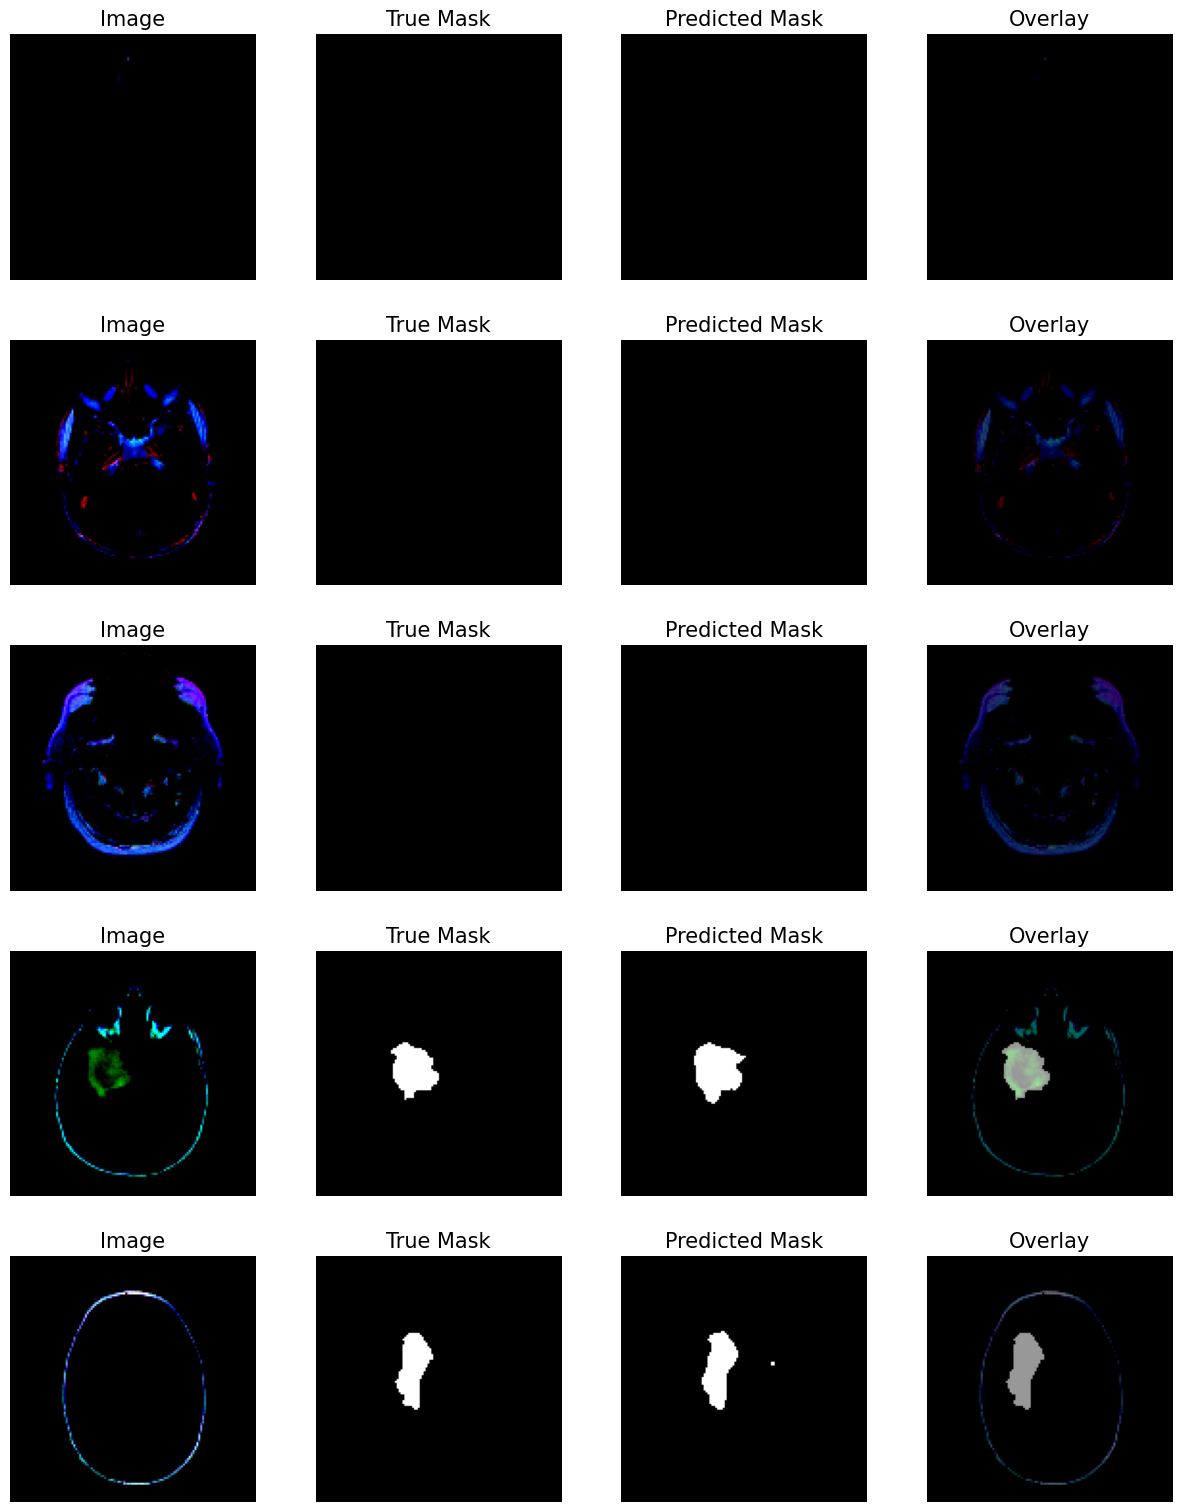

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid

def predict_and_plot(model, dataset, num_samples=5):
    model.eval()
    fig = plt.figure(figsize=(15, 20))  # Adjusted figure size for larger images
    grid = ImageGrid(fig, 111, nrows_ncols=(num_samples, 4), axes_pad=0.6)

    for i in range(num_samples):
        image, mask = dataset[i]
        image = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image).cpu().squeeze(0).numpy()
            output = (output > 0.5).astype(np.uint8)

        image = np.transpose(image.cpu().numpy().squeeze(), (1, 2, 0))
        mask = mask.squeeze().numpy()
        
        # Clip output values to ensure they are in the valid range
        output = np.clip(output, 0, 1)

        # Ensure the output mask has the correct shape for display
        if output.ndim == 3 and output.shape[0] == 1:
            output = output.squeeze(0)

        # Original Image
        grid[i*4].imshow(image)
        grid[i*4].set_title('Image', fontsize=15)
        grid[i*4].axis('off')

        # True Mask
        grid[i*4+1].imshow(mask, cmap='gray')
        grid[i*4+1].set_title('True Mask', fontsize=15)
        grid[i*4+1].axis('off')

        # Predicted Mask
        grid[i*4+2].imshow(output, cmap='gray')
        grid[i*4+2].set_title('Predicted Mask', fontsize=15)
        grid[i*4+2].axis('off')

        # Overlay
        grid[i*4+3].imshow(image)
        grid[i*4+3].imshow(mask, alpha=0.6, cmap='gray')
        grid[i*4+3].set_title('Overlay', fontsize=15)
        grid[i*4+3].axis('off')

    plt.show()

# Predict and plot for some samples from the test dataset
predict_and_plot(model, test_ds, num_samples=5)
